In [1]:
print(
"""
************************************************************
Author: Shota DEGUCHI
        Strucural Analysis Lab. Kyushu Uni. (July 19, 2021)
************************************************************
""")


import sys
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np
import pandas as pd
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
# import seaborn as sns
import time
import datetime

print("current python version:", sys.version)
print("        tf     version:", tf.__version__)


************************************************************
Author: Shota DEGUCHI
        Strucural Analysis Lab. Kyushu Uni. (July 19, 2021)
************************************************************

current python version: 3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
        tf     version: 2.5.0


In [2]:
############################################################
################      HYPER PARAMETERS      ################
############################################################

lr      = 1e-3
c_tol   = 1e-3
n_btch  = 2 ** 7   # 2 ** x: 5 => 32, 6 => 64, 7 => 128, 8 => 256
n_epch  = int(5e3)
f_mntr  = int(1e1)
layers  = [3] + 7 * [20] + [3]
gpu_flg = 0   # 0, 1, 2, or 4 (see: https://www.tensorflow.org/guide/gpu)
              # 0: Restrict TensorFlow to only use the first GPU
              # 1: Currently, memory growth needs to be the same across GPUs
              # 2: Create 2 virtual GPUs with 1GB memory each
              # 4: Create 4 virtual GPUs with 1GB memory each

seed    = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpu_flg == 0:
    print("gpu_flg:", gpu_flg)
    if gpus:
        # Restrict TensorFlow to only use the first GPU
        try:
            tf.config.experimental.set_visible_devices(gpus[0], "GPU")
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)
    
elif gpu_flg == 1:
    print("gpu_flg:", gpu_flg)
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    
elif gpu_flg == 2:
    print("gpu_flg:", gpu_flg)
    if gpus:
        # Create 2 virtual GPUs with 1GB memory each
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10),
                 tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10)])
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
            
elif gpu_flg == 4:
    print("gpu_flg:", gpu_flg)
    if gpus:
        # Create 4 virtual GPUs with 1GB memory each
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10),
                 tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10),
                 tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10),
                 tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10)])
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)

else:
    print(">>>>> ERROR: gpu_flg not specified properly")

gpu_flg: 0
2 Physical GPUs, 1 Logical GPU


In [4]:
class PINN:
    def __init__(self, 
                 x_trn, y_trn, t_trn, u_trn, v_trn, 
                 x_val, y_val, t_val, u_val, v_val, 
                 layers, activ = "tanh", w_init = "Glorot",
                 w_prd = 1., w_pde = 1.):
        
        # bounds
        X_trn = np.concatenate([x_trn, y_trn, t_trn], 1)
        self.lb = X_trn.min(0)
        self.ub = X_trn.max(0)
        
        # training set
        self.x_trn = x_trn; self.y_trn = y_trn; self.t_trn = t_trn
        self.u_trn = u_trn; self.v_trn = v_trn
        
        # validation set
        self.x_val = x_val; self.y_val = y_val; self.t_val = t_val
        self.u_val = u_val; self.v_val = v_val
        
        # initialize NN
        self.layers = layers
        self.dtype  = tf.float64
        self.activ  = activ    # selects activation function 
        self.w_init = w_init   # selects weight initializer
#         self.weights, self.biases = self.initialize_NN(layers)
        self.weights, self.biases, self.params = self.initialize_NN(layers)
    
        # track input
        self.dist_U = np.array([])
        
        # weight for loss terms
        self.w_prd = w_prd
        self.w_pde = w_pde
        
        # epoch counter
        self.ep_log = np.array([])
        
        # track train loss
        self.loss_trn_log      = np.array([])
        self.loss_pred_trn_log = np.array([])
        self.loss_phys_trn_log = np.array([])
        
        # track val loss
        self.loss_val_log      = np.array([])
        self.loss_pred_val_log = np.array([])
        self.loss_phys_val_log = np.array([])

        # parameter setting
        self.rhoi = 1.
        self.nu   = .01
#         self.rho_log = np.array([])
#         self.nu_log  = np.array([])
#         self.rhoi = tf.Variable([.1], dtype = self.dtype)
#         self.nu   = tf.Variable([.1], dtype = self.dtype)
        
#         self.sess = tf.Session(config = tf.ConfigProto(allow_soft_placement = True, log_device_placement = True))
        
#         # variables for training
#         self.x_trn_tf = tf.placeholder(tf.float64, shape = [None, self.x_trn.shape[1]])
#         self.y_trn_tf = tf.placeholder(tf.float64, shape = [None, self.y_trn.shape[1]])
#         self.t_trn_tf = tf.placeholder(tf.float64, shape = [None, self.t_trn.shape[1]])
#         self.u_trn_tf = tf.placeholder(tf.float64, shape = [None, self.u_trn.shape[1]])
#         self.v_trn_tf = tf.placeholder(tf.float64, shape = [None, self.v_trn.shape[1]])
        
#         # variables for validating
#         self.x_val_tf   = tf.placeholder(tf.float64, shape = [None, self.x_val.shape[1]])
#         self.y_val_tf   = tf.placeholder(tf.float64, shape = [None, self.y_val.shape[1]])
#         self.t_val_tf   = tf.placeholder(tf.float64, shape = [None, self.t_val.shape[1]])
#         self.u_val_tf   = tf.placeholder(tf.float64, shape = [None, self.u_val.shape[1]])
#         self.v_val_tf   = tf.placeholder(tf.float64, shape = [None, self.v_val.shape[1]])
        
        # training loss
#         self.u_pred_trn, self.v_pred_trn, self.p_pred_trn, self.fu_pred_trn, self.fv_pred_trn = self.PDE(self.x_trn, self.y_trn, self.t_trn)
#         self.loss_pred_trn = w0 * (  tf.reduce_mean(tf.square(self.u_trn - self.u_pred_trn)) \
#                                      + tf.reduce_mean(tf.square(self.v_trn - self.v_pred_trn)))
#         self.loss_phys_trn = w1 * (  tf.reduce_mean(tf.square(self.fu_pred_trn)) \
#                                      + tf.reduce_mean(tf.square(self.fv_pred_trn)))
#         self.loss_trn      = self.loss_pred_trn + self.loss_phys_trn
        
        # validation loss
#         self.u_pred_val, self.v_pred_val, self.p_pred_val, self.fu_pred_val, self.fv_pred_val = self.PDE(self.x_val, self.y_val, self.t_val)
#         self.loss_pred_val = w0 * (  tf.reduce_mean(tf.square(self.u_val - self.u_pred_val)) \
#                                    + tf.reduce_mean(tf.square(self.v_val - self.v_pred_val)))
#         self.loss_phys_val = w1 * (  tf.reduce_mean(tf.square(self.fu_pred_val)) \
#                                    + tf.reduce_mean(tf.square(self.fv_pred_val)))
#         self.loss_val      = self.loss_pred_val + self.loss_phys_val
        
        # optimizer (e.g. # AdadeltaOptimizer / AdagradOptimizer / AdamOptimizer / RMSPropOptimizer / etc.)
#         self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr, amsgrad = False)
        self.optimizer = self.optimizer(opt_name = "Adam")
        
################################################################
#         self.loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
#         self.loss_val   = self.loss_glb(x_val,   y_val,   t_val,   u_val,   v_val)
#         self.train_op = self.optimizer.minimize(self.loss_trn, var_list = self.params)
################################################################
        
#         init = tf.global_variables_initializer()
#         self.sess.run(init)

    def optimizer(self, lr = lr, opt_name = "Adam"):
        if   opt_name == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt_name == "Adadelta":
            optimizer = tf.keras.optimizers.Adadelta(learning_rate = lr, rho = 0.95)
        elif opt_name == "Adagrad":
            optimizer = tf.keras.optimizers.Adagrad(learning_rate = lr, initial_accumulator_value = 0.1)
        elif opt_name == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt_name == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt_name == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt_name == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def initialize_NN(self, layers):        
        weights = []
        biases  = []
        params  = []
        
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.weight_init(size = [layers[l], layers[l + 1]])
#             W = tf.Variable(tf.random.normal([layers[l], layers[l + 1]], dtype = self.dtype), name = "W" + str(l + 1))
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype = self.dtype), dtype = self.dtype, name = "b" + str(l + 1))
            
            weights.append(W)
            biases.append(b)
            
            params.append(W)
            params.append(b)
            
        return weights, biases, params
        
    def weight_init(self, size):
        w_init  = self.w_init
        in_dim  = size[0]
        out_dim = size[1]
        
        if   w_init == "Glorot":
            stdev = np.sqrt(2 / (in_dim + out_dim))
        elif w_init == "He":
            stdev = np.sqrt(2 / in_dim)
        elif w_init == "LeCun":
            stdev = np.sqrt(1 / in_dim)
        else:
            raise Exception(">>>>> Exception: weight initializer not specified correctly")
        
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev = stdev, dtype = self.dtype), dtype = self.dtype)
    
    def neural_net(self, X, weights, biases):
        # forward pass
        
        activ = self.activ
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            U = tf.add(tf.matmul(H, W), b)
            
#             print("l:", l, "U:", U.shape)
#             print("l:", l, "W:", W.shape)
#             print("l:", l, "b:", b.shape)
            
            self.dist_U = np.append(self.dist_U, U)
            
            if activ == "tanh":
                H = tf.tanh(U)
            elif activ == "gelu":
                H = tf.multiply(U, tf.sigmoid(1.702 * U))
            elif activ == "silu" or activ == "swish-1":
                H = tf.multiply(U, tf.sigmoid(U))
            elif activ == "mish":
                H = tf.multiply(U, tf.tanh(tf.nn.softplus(U)))
            else:
                raise Exception(">>>>> Exception: activation function not specified correctly")
        
        W = weights[-1]
        b = biases[-1]
#         print("l: 7 W:", W.shape)
#         print("l: 7 b:", b.shape)
        
        U = tf.add(tf.matmul(H, W), b)
        Z = U   # identity mapping for the last layer
        Y = Z
        return Y
        
    def PDE(self, x, y, t):
        rhoi = self.rhoi
        nu   = self.nu
        
        x = tf.convert_to_tensor(x)
        y = tf.convert_to_tensor(y)
        t = tf.convert_to_tensor(t)

        with tf.GradientTape(persistent = True) as tp1:
            tp1.watch(x)
            tp1.watch(y)
            tp1.watch(t)
            with tf.GradientTape(persistent = True) as tp2:
                tp2.watch(x)
                tp2.watch(y)
                tp2.watch(t)
                with tf.GradientTape(persistent = True) as tp3:
                    tp3.watch(x)
                    tp3.watch(y)
                    tp3.watch(t)
                    
#                     psi_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
#                     psi = psi_p[:,0:1]
#                     p = psi_p[:,1:2]

                    u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
                    u = u_v_p[:,0:1]
                    v = u_v_p[:,1:2]
                    p = u_v_p[:,2:3]
                
#                 u   =   tp3.gradient(psi, y)
#                 v   = - tp3.gradient(psi, x)
                p_x =   tp3.gradient(p, x)
                p_y =   tp3.gradient(p, y)
                del tp3
                
            u_t = tp2.gradient(u, t)
            u_x = tp2.gradient(u, x)
            u_y = tp2.gradient(u, y)
            v_t = tp2.gradient(v, t)
            v_x = tp2.gradient(v, x)
            v_y = tp2.gradient(v, y)
            del tp2
            
        u_xx = tp1.gradient(u_x, x)
        u_yy = tp1.gradient(u_y, y)
        v_xx = tp1.gradient(v_x, x)
        v_yy = tp1.gradient(v_y, y)
        del tp1
        
        gv_x = u_t + u * u_x + v * u_y + rhoi * p_x - nu * (u_xx + u_yy)
        gv_y = v_t + u * v_x + v * v_y + rhoi * p_y - nu * (v_xx + v_yy)
        
        return u, v, p, gv_x, gv_y

    def loss_prd(self, x, y, t, u, v):
        u_hat, v_hat, p_hat, dummy, dummy = self.PDE(x, y, t)
        loss_prd =    tf.reduce_mean(tf.square(u - u_hat)) \
                    + tf.reduce_mean(tf.square(v - v_hat))
        loss_prd = self.w_prd * loss_prd
        
        return loss_prd
        
    def loss_pde(self, x, y, t):
        dummy, dummy, dummy, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        loss_pde =    tf.reduce_mean(tf.square(gv_x_hat)) \
                    + tf.reduce_mean(tf.square(gv_y_hat))
        loss_pde = self.w_pde * loss_pde
        
        return loss_pde
    
#     def loss_ic (self, ):
#         loss_ic  = ...
#         loss_ic  = w_ic * loss_ic
#         return loss_ic
    
#     def loss_bc (self, ):
#         loss_bc  = ...
#         loss_bc  = w_bc * loss_bc
#         return loss_bc
    
    def loss_glb(self, x, y, t, u, v):
        loss_glb = self.loss_prd(x, y, t, u, v) + self.loss_pde(x, y, t)
        
        return loss_glb

    def loss_grad(self, x, y, t, u, v):
        with tf.GradientTape() as tp:
            loss = self.loss_glb(x, y, t, u, v)
        grad = tp.gradient(loss, self.params)

        return loss, grad
        
#     def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
    def train(self, epoch = 10 ** 5, tol = 1e-5): 
        
        # training set
        x_trn = self.x_trn; y_trn = self.y_trn; t_trn = self.t_trn
        u_trn = self.u_trn; v_trn = self.v_trn
        
        # validation set
        x_val = self.x_val; y_val = self.y_val; t_val = self.t_val
        u_val = self.u_val; v_val = self.v_val
        
#         tf_dict_val = {self.x_val_tf: self.x_val, self.y_val_tf: self.y_val, self.t_val_tf: self.t_val, 
#                        self.u_val_tf: self.u_val, self.v_val_tf: self.v_val}

        t0 = time.time()
        n_data = self.x_trn.shape[0]
        
        for ep in range(epoch):
            loss, grad = self.loss_grad(x_trn, y_trn, t_trn, u_trn, v_trn)   # find a gradient to descent
            self.optimizer.apply_gradients(zip(grad, self.params))           # back-prop
            print("ep: %d, loss: %.6e" % (ep, loss))
            
#             sff_idx = np.random.permutation(n_data)

#             for idx in range(0, n_data, batch):
#                 x_trn_batch = self.x_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 y_trn_batch = self.y_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 t_trn_batch = self.t_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 u_trn_batch = self.u_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 v_trn_batch = self.v_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 tf_dict_trn = {self.x_trn_tf: x_trn_batch, self.y_trn_tf: y_trn_batch, self.t_trn_tf: t_trn_batch, self.u_trn_tf: u_trn_batch, self.v_trn_tf: v_trn_batch}
                
#                 self.sess.run(self.train_op, tf_dict_trn)
            
#             if ep == 0: 
#                 # training loss
#                 ep0_loss_trn      = self.sess.run(self.loss_trn,      tf_dict_trn)
#                 ep0_loss_pred_trn = self.sess.run(self.loss_pred_trn, tf_dict_trn)
#                 ep0_loss_phys_trn = self.sess.run(self.loss_phys_trn, tf_dict_trn)
                
#                 # validation loss
#                 ep0_loss_val        = self.sess.run(self.loss_val,      tf_dict_val)
#                 ep0_loss_pred_val   = self.sess.run(self.loss_pred_val, tf_dict_val)
#                 ep0_loss_phys_val   = self.sess.run(self.loss_phys_val, tf_dict_val)
                
#                 print(">>>>> initial state; loss_trn: %.6e, loss_val: %.6e" % (ep0_loss_trn, ep0_loss_val))
            
            # epoch counter
#             self.ep_log = np.append(self.ep_log, ep)

            # training loss
#             ep_loss_trn      = self.sess.run(self.loss_trn,      tf_dict_trn) # / ep0_loss_trn
#             ep_loss_pred_trn = self.sess.run(self.loss_pred_trn, tf_dict_trn)
#             ep_loss_phys_trn = self.sess.run(self.loss_phys_trn, tf_dict_trn)

#             self.loss_trn_log      = np.append(self.loss_trn_log,      ep_loss_trn)
#             self.loss_pred_trn_log = np.append(self.loss_pred_trn_log, ep_loss_pred_trn)
#             self.loss_phys_trn_log = np.append(self.loss_phys_trn_log, ep_loss_phys_trn)

            # track val loss
#             ep_loss_val      = self.sess.run(self.loss_val,      tf_dict_val)
#             ep_loss_pred_val = self.sess.run(self.loss_pred_val, tf_dict_val)
#             ep_loss_phys_val = self.sess.run(self.loss_phys_val, tf_dict_val)

#             self.loss_val_log      = np.append(self.loss_val_log,      ep_loss_val)
#             self.loss_pred_val_log = np.append(self.loss_pred_val_log, ep_loss_pred_val)
#             self.loss_phys_val_log = np.append(self.loss_phys_val_log, ep_loss_phys_val)

            # parameter estimation
#             ep_rho  = 1 / self.sess.run(self.rhoi)
#             ep_nu   = self.sess.run(self.nu)

#             self.rho_log = np.append(self.rho_log, ep_rho)
#             self.nu_log  = np.append(self.nu_log,  ep_nu)
                
#             if ep % f_mntr == 0:
#                 elps = time.time() - t0

#                 # training loss
#                 ep_loss_trn      = self.sess.run(self.loss_trn,      tf_dict_trn)
#                 ep_loss_pred_trn = self.sess.run(self.loss_pred_trn, tf_dict_trn)
#                 ep_loss_phys_trn = self.sess.run(self.loss_phys_trn, tf_dict_trn)
                
#                 # track val loss
#                 ep_loss_val      = self.sess.run(self.loss_val,      tf_dict_val)
#                 ep_loss_pred_val = self.sess.run(self.loss_pred_val, tf_dict_val)
#                 ep_loss_phys_val = self.sess.run(self.loss_phys_val, tf_dict_val)
                
#                 # parameter estimation
#                 ep_rho  = 1 / self.sess.run(self.rhoi)
#                 ep_nu   = self.sess.run(self.nu)
                
#                 print('ep: %d, loss_trn: %.3e, loss_val: %.3e, rho: %.6e, nu: %.6e, elps: %.3f' % (ep, ep_loss_trn, ep_loss_val, ep_rho, ep_nu, elps))
                
#                 t0 = time.time()
        
#                 if ep_loss_trn < tol:
#                     print(">>>>> program terminating with the loss converging to its tolerance.")
#                     break
        
#     def predict(self, x_star, y_star, t_star):
#         tf_dict = {self.x_trn_tf: x_star, self.y_trn_tf: y_star, self.t_trn_tf: t_star}
        
#         u_star = self.sess.run(self.u_pred_trn, tf_dict)
#         v_star = self.sess.run(self.v_pred_trn, tf_dict)
#         p_star = self.sess.run(self.p_pred_trn, tf_dict)
        
#         return u_star, v_star, p_star
    
    def predict(self, x, y, t):
        u_hat, v_hat, p_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        return u_hat, v_hat, p_hat, gv_x_hat, gv_y_hat

In [4]:
class PINN2:
    def __init__(self, 
                 x_trn, y_trn, t_trn, u_trn, v_trn, 
                 x_val, y_val, t_val, u_val, v_val, 
                 layers, activ = "tanh", w_init = "Glorot",
                 w_prd = 1., w_pde = 1.):
        
        # bounds
        X_trn = np.concatenate([x_trn, y_trn, t_trn], 1)
        self.lb = X_trn.min(0)
        self.ub = X_trn.max(0)
        
        # training set
        self.x_trn = x_trn; self.y_trn = y_trn; self.t_trn = t_trn
        self.u_trn = u_trn; self.v_trn = v_trn
        
        # validation set
        self.x_val = x_val; self.y_val = y_val; self.t_val = t_val
        self.u_val = u_val; self.v_val = v_val
        
        # initialize NN
        self.layers = layers
        self.dtype  = tf.float64
        self.activ  = activ    # selects activation function (tanh / swish / etc.)
        self.w_init = w_init   # selects weight initializer (Glorot / He / LeCun)
        self.weights, self.biases, self.params = self.initialize_NN(layers)
        self.optimizer = self.optimizer(opt_name = "Adam")   # optimizer (e.g. SGD / Adam / RMSprop / etc.)
    
        # track input
        self.dist_U = []
        
        # weight for loss terms
        self.w_prd = w_prd
        self.w_pde = w_pde
        
        # epoch counter
        self.ep_log = np.array([])
        
        # track train loss
        self.loss_trn_log     = np.array([])
        self.loss_prd_trn_log = np.array([])
        self.loss_pde_trn_log = np.array([])
        
        # track val loss
        self.loss_val_log     = np.array([])
        self.loss_prd_val_log = np.array([])
        self.loss_pde_val_log = np.array([])

        # parameter setting
        self.rhoi = 1.
        self.nu   = .01
#         self.rho_log = np.array([])
#         self.nu_log  = np.array([])
#         self.rhoi = tf.Variable([.1], dtype = self.dtype)
#         self.nu   = tf.Variable([.1], dtype = self.dtype)
        
    def optimizer(self, lr = lr, opt_name = "Adam"):
        if   opt_name == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt_name == "Adadelta":
            optimizer = tf.keras.optimizers.Adadelta(learning_rate = lr, rho = 0.95)
        elif opt_name == "Adagrad":
            optimizer = tf.keras.optimizers.Adagrad(learning_rate = lr, initial_accumulator_value = 0.1)
        elif opt_name == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt_name == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt_name == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt_name == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def initialize_NN(self, layers):
        weights = []
        biases  = []
        params  = []
        
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.weight_init(size = [layers[l], layers[l + 1]], depth = l)
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype = self.dtype), dtype = self.dtype, name = "b" + str(l))
            weights.append(W)
            biases.append(b)
            params.append(W)
            params.append(b)
            
        return weights, biases, params
        
    def weight_init(self, size, depth):
        w_init  = self.w_init
        in_dim  = size[0]
        out_dim = size[1]
        
        if   w_init == "Glorot":
            stdev = np.sqrt(2 / (in_dim + out_dim))
        elif w_init == "He":
            stdev = np.sqrt(2 / in_dim)
        elif w_init == "LeCun":
            stdev = np.sqrt(1 / in_dim)
        else:
            raise Exception(">>>>> Exception: weight initializer not specified correctly")
        
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev = stdev, dtype = self.dtype), dtype = self.dtype, name = "W" + str(depth))
    
    def neural_net(self, X, weights, biases):   # forward pass
        activ = self.activ
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            U = tf.add(tf.matmul(H, W), b)
            
#             print("l:", l, "shape:", U.shape, "U:", U)
#             print("l:", l, "U:", U.shape)
#             print("l:", l, "U:", U[:,0].shape)
            
            self.dist_U.append(U[:,0])
            
            if activ == "tanh":
                H = tf.tanh(U)
            elif activ == "gelu":
                H = tf.multiply(U, tf.sigmoid(1.702 * U))
            elif activ == "silu" or activ == "swish-1":
                H = tf.multiply(U, tf.sigmoid(U))
            elif activ == "mish":
                H = tf.multiply(U, tf.tanh(tf.nn.softplus(U)))
            else:
                raise Exception(">>>>> Exception: activation function not specified correctly")
        
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(H, W), b)
        Z = U   # identity mapping for the last layer
        Y = Z
        return Y
        
    def PDE(self, x, y, t):
        rhoi = self.rhoi
        nu   = self.nu
        
        x = tf.convert_to_tensor(x)
        y = tf.convert_to_tensor(y)
        t = tf.convert_to_tensor(t)

        with tf.GradientTape(persistent = True) as tp1:
            tp1.watch(x)
            tp1.watch(y)
            tp1.watch(t)
            with tf.GradientTape(persistent = True) as tp2:
                tp2.watch(x)
                tp2.watch(y)
                tp2.watch(t)
                with tf.GradientTape(persistent = True) as tp3:
                    tp3.watch(x)
                    tp3.watch(y)
                    tp3.watch(t)
                    
                    u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
                    u = u_v_p[:,0:1]
                    v = u_v_p[:,1:2]
                    p = u_v_p[:,2:3]
                
                p_x =   tp3.gradient(p, x)
                p_y =   tp3.gradient(p, y)
                del tp3
                
            u_t = tp2.gradient(u, t)
            u_x = tp2.gradient(u, x)
            u_y = tp2.gradient(u, y)
            v_t = tp2.gradient(v, t)
            v_x = tp2.gradient(v, x)
            v_y = tp2.gradient(v, y)
            del tp2
            
        u_xx = tp1.gradient(u_x, x)
        u_yy = tp1.gradient(u_y, y)
        v_xx = tp1.gradient(v_x, x)
        v_yy = tp1.gradient(v_y, y)
        del tp1
        
        gv_c = u_x + v_y                                                   # continuity
        gv_x = u_t + u * u_x + v * u_y + rhoi * p_x - nu * (u_xx + u_yy)   # momentum
        gv_y = v_t + u * v_x + v * v_y + rhoi * p_y - nu * (v_xx + v_yy)
        
        return u, v, p, gv_c, gv_x, gv_y

    def loss_prd(self, x, y, t, u, v):
        u_hat, v_hat, p_hat, dummy, dummy, dummy = self.PDE(x, y, t)
        loss_prd =    tf.reduce_mean(tf.square(u - u_hat)) \
                    + tf.reduce_mean(tf.square(v - v_hat))
        loss_prd = self.w_prd * loss_prd
        
        return loss_prd
        
    def loss_pde(self, x, y, t):
        dummy, dummy, dummy, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        
        loss_pde =    tf.reduce_mean(tf.square(gv_c_hat)) \
                    + tf.reduce_mean(tf.square(gv_x_hat)) \
                    + tf.reduce_mean(tf.square(gv_y_hat))
        loss_pde = self.w_pde * loss_pde
        
        return loss_pde
    
#     def loss_ic (self, ):
#         loss_ic  = ...
#         loss_ic  = w_ic * loss_ic
#         return loss_ic
    
#     def loss_bc (self, ):
#         loss_bc  = ...
#         loss_bc  = w_bc * loss_bc
#         return loss_bc
    
    def loss_glb(self, x, y, t, u, v):
#         loss_glb = self.loss_prd(x, y, t, u, v) + self.loss_pde(x, y, t) + self.loss_ic(x, y, t) + self.loss_bc(x, y, t)
        loss_glb = self.loss_prd(x, y, t, u, v) + self.loss_pde(x, y, t)
        
        return loss_glb

    def loss_grad(self, x, y, t, u, v):
        with tf.GradientTape() as tp:
            loss = self.loss_glb(x, y, t, u, v)
        grad = tp.gradient(loss, self.params)

        return loss, grad
        
#     def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
    def train(self, epoch = 10 ** 5, tol = 1e-5): 
        # training set
        x_trn = self.x_trn; y_trn = self.y_trn; t_trn = self.t_trn
        u_trn = self.u_trn; v_trn = self.v_trn
        
        # validation set
        x_val = self.x_val; y_val = self.y_val; t_val = self.t_val
        u_val = self.u_val; v_val = self.v_val
        
        t0 = time.time()
        n_data = self.x_trn.shape[0]
        
        for ep in range(epoch):
            loss_trn, grad_trn = self.loss_grad(x_trn, y_trn, t_trn, u_trn, v_trn)   # find a gradient to descent
            self.optimizer.apply_gradients(zip(grad_trn, self.params))               # back-prop
            
            ep_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
            ep_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
            
            self.ep_log       = np.append(self.ep_log, ep)
            self.loss_trn_log = np.append(self.loss_trn_log, ep_loss_trn)
            self.loss_val_log = np.append(self.loss_val_log, ep_loss_val)
            
            if ep == 0:
                ep0_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
                ep0_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
                print(">>>>> initial state; loss_trn: %.6e, loss_val: %.6e" % (ep0_loss_trn, ep0_loss_val))
                
            if ep % f_mntr == 0:
                elps = time.time() - t0
                print("ep: %d, loss_trn: %.6e, loss_val: %.6e, elps: %.3f" % (ep, ep_loss_trn, ep_loss_val, elps))
                t0 = time.time()
                
            if ep_loss_trn < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                break

#             sff_idx = np.random.permutation(n_data)

#             for idx in range(0, n_data, batch):
#                 x_trn_batch = self.x_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 y_trn_batch = self.y_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 t_trn_batch = self.t_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 u_trn_batch = self.u_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 v_trn_batch = self.v_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 tf_dict_trn = {self.x_trn_tf: x_trn_batch, self.y_trn_tf: y_trn_batch, self.t_trn_tf: t_trn_batch, self.u_trn_tf: u_trn_batch, self.v_trn_tf: v_trn_batch}
                
#                 self.sess.run(self.train_op, tf_dict_trn)
        
    def predict(self, x, y, t):
        u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        return u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat

In [6]:
class PINN3:
    def __init__(self, 
                 x_trn, y_trn, t_trn, u_trn, v_trn, 
                 x_val, y_val, t_val, u_val, v_val, 
                 layers, activ = "tanh", w_init = "Glorot",
                 w_prd = 1., w_pde = 1.):
        
        # bounds
        X_trn = np.concatenate([x_trn, y_trn, t_trn], 1)
        self.lb = X_trn.min(0)
        self.ub = X_trn.max(0)
        
        # training set
        self.x_trn = x_trn; self.y_trn = y_trn; self.t_trn = t_trn
        self.u_trn = u_trn; self.v_trn = v_trn
        
        # validation set
        self.x_val = x_val; self.y_val = y_val; self.t_val = t_val
        self.u_val = u_val; self.v_val = v_val
        
        # initialize NN
        self.layers = layers
        self.dtype  = tf.float64
        self.activ  = activ    # selects activation function (tanh / swish / etc.)
        self.w_init = w_init   # selects weight initializer (Glorot / He / LeCun)
        self.weights, self.biases, self.params = self.initialize_NN(layers)
        self.optimizer = self.optimizer(opt_name = "Adam")   # optimizer (e.g. SGD / Adam / RMSprop / etc.)
    
        # track input
        self.dist_U = []
        
        # weight for loss terms
        self.w_prd = w_prd
        self.w_pde = w_pde
        
        # epoch counter
        self.ep_log = np.array([])
        
        # track train loss
        self.loss_trn_log     = np.array([])
        self.loss_prd_trn_log = np.array([])
        self.loss_pde_trn_log = np.array([])
        
        # track val loss
        self.loss_val_log     = np.array([])
        self.loss_prd_val_log = np.array([])
        self.loss_pde_val_log = np.array([])

        # parameter setting
        self.rhoi = 1.
        self.nu   = .01
#         self.rho_log = np.array([])
#         self.nu_log  = np.array([])
#         self.rhoi = tf.Variable([.1], dtype = self.dtype)
#         self.nu   = tf.Variable([.1], dtype = self.dtype)
        
    def optimizer(self, lr = lr, opt_name = "Adam"):
        if   opt_name == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt_name == "Adadelta":
            optimizer = tf.keras.optimizers.Adadelta(learning_rate = lr, rho = 0.95)
        elif opt_name == "Adagrad":
            optimizer = tf.keras.optimizers.Adagrad(learning_rate = lr, initial_accumulator_value = 0.1)
        elif opt_name == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt_name == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt_name == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt_name == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def initialize_NN(self, layers):
        weights = []
        biases  = []
        params  = []
        
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.weight_init(size = [layers[l], layers[l + 1]], depth = l)
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype = self.dtype), dtype = self.dtype, name = "b" + str(l))
            weights.append(W)
            biases.append(b)
            params.append(W)
            params.append(b)
            
        return weights, biases, params
        
    def weight_init(self, size, depth):
        w_init  = self.w_init
        in_dim  = size[0]
        out_dim = size[1]
        
        if   w_init == "Glorot":
            stdev = np.sqrt(2 / (in_dim + out_dim))
        elif w_init == "He":
            stdev = np.sqrt(2 / in_dim)
        elif w_init == "LeCun":
            stdev = np.sqrt(1 / in_dim)
        else:
            raise Exception(">>>>> Exception: weight initializer not specified correctly")
        
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev = stdev, dtype = self.dtype), dtype = self.dtype, name = "W" + str(depth))
    
    def neural_net(self, X, weights, biases):   # forward pass
        activ = self.activ
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            U = tf.add(tf.matmul(H, W), b)
            
#             print("l:", l, "shape:", U.shape, "U:", U)
#             print("l:", l, "U:", U.shape)
#             print("l:", l, "U:", U[:,0].shape)
            
            self.dist_U.append(U[:,0])
            
            if activ == "tanh":
                H = tf.tanh(U)
            elif activ == "gelu":
                H = tf.multiply(U, tf.sigmoid(1.702 * U))
            elif activ == "silu" or activ == "swish-1":
                H = tf.multiply(U, tf.sigmoid(U))
            elif activ == "mish":
                H = tf.multiply(U, tf.tanh(tf.nn.softplus(U)))
            else:
                raise Exception(">>>>> Exception: activation function not specified correctly")
        
        W = weights[-1]
        b = biases [-1]
        U = tf.add(tf.matmul(H, W), b)
        Z = U   # identity mapping for the last layer
        Y = Z
        return Y
        
    def PDE(self, x, y, t):
        rhoi = self.rhoi
        nu   = self.nu
        
        x = tf.convert_to_tensor(x)
        y = tf.convert_to_tensor(y)
        t = tf.convert_to_tensor(t)

        with tf.GradientTape(persistent = True) as tp1:
            tp1.watch(x)
            tp1.watch(y)
            tp1.watch(t)
            with tf.GradientTape(persistent = True) as tp2:
                tp2.watch(x)
                tp2.watch(y)
                tp2.watch(t)
                with tf.GradientTape(persistent = True) as tp3:
                    tp3.watch(x)
                    tp3.watch(y)
                    tp3.watch(t)
                    
                    u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
                    u = u_v_p[:, 0:1]
                    v = u_v_p[:, 1:2]
                    p = u_v_p[:, 2:3]
                
                p_x =   tp3.gradient(p, x)
                p_y =   tp3.gradient(p, y)
                del tp3
                
            u_t = tp2.gradient(u, t)
            u_x = tp2.gradient(u, x)
            u_y = tp2.gradient(u, y)
            v_t = tp2.gradient(v, t)
            v_x = tp2.gradient(v, x)
            v_y = tp2.gradient(v, y)
            del tp2
            
        u_xx = tp1.gradient(u_x, x)
        u_yy = tp1.gradient(u_y, y)
        v_xx = tp1.gradient(v_x, x)
        v_yy = tp1.gradient(v_y, y)
        del tp1
        
        gv_c = u_x + v_y                                                   # continuity
        gv_x = u_t + u * u_x + v * u_y + rhoi * p_x - nu * (u_xx + u_yy)   # momentum
        gv_y = v_t + u * v_x + v * v_y + rhoi * p_y - nu * (v_xx + v_yy)
        
        return u, v, p, gv_c, gv_x, gv_y

    def loss_prd(self, x, y, t, u, v):
        u_hat, v_hat, p_hat, dummy, dummy, dummy = self.PDE(x, y, t)
        loss_prd =    tf.reduce_mean(tf.square(u - u_hat)) \
                    + tf.reduce_mean(tf.square(v - v_hat))
        loss_prd = self.w_prd * loss_prd
        
        return loss_prd
        
    def loss_pde(self, x, y, t):
        dummy, dummy, dummy, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        
        loss_pde =    tf.reduce_mean(tf.square(gv_c_hat)) \
                    + tf.reduce_mean(tf.square(gv_x_hat)) \
                    + tf.reduce_mean(tf.square(gv_y_hat))
        loss_pde = self.w_pde * loss_pde
        
        return loss_pde
    
#     def loss_ic (self, ):
#         loss_ic  = ...
#         loss_ic  = w_ic * loss_ic
#         return loss_ic
    
#     def loss_bc (self, ):
#         loss_bc  = ...
#         loss_bc  = w_bc * loss_bc
#         return loss_bc
    
    def loss_glb(self, x, y, t, u, v):
#         loss_glb = self.loss_prd(x, y, t, u, v) + self.loss_pde(x, y, t) + self.loss_ic(x, y, t) + self.loss_bc(x, y, t)
        loss_glb = self.loss_prd(x, y, t, u, v) + self.loss_pde(x, y, t)
        
        return loss_glb

    def loss_grad(self, x, y, t, u, v):
        with tf.GradientTape() as tp:
            loss = self.loss_glb(x, y, t, u, v)
        grad = tp.gradient(loss, self.params)

        return loss, grad
        
    def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
        # training set
        x_trn = self.x_trn; y_trn = self.y_trn; t_trn = self.t_trn
        u_trn = self.u_trn; v_trn = self.v_trn
        
        # validation set
        x_val = self.x_val; y_val = self.y_val; t_val = self.t_val
        u_val = self.u_val; v_val = self.v_val
        
        t0 = time.time()
        n_data = self.x_trn.shape[0]

        for ep in range(epoch):
            loss_trn, grad_trn = self.loss_grad(x_trn, y_trn, t_trn, u_trn, v_trn)   # find a gradient to descent
            self.optimizer.apply_gradients(zip(grad_trn, self.params))               # back-prop
            
            ep_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
            ep_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
            
            self.ep_log       = np.append(self.ep_log, ep)
            self.loss_trn_log = np.append(self.loss_trn_log, ep_loss_trn)
            self.loss_val_log = np.append(self.loss_val_log, ep_loss_val)
            
            if ep == 0:
                ep0_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
                ep0_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
                print(">>>>> initial state; loss_trn: %.6e, loss_val: %.6e" % (ep0_loss_trn, ep0_loss_val))
                
            if ep % f_mntr == 0:
                elps = time.time() - t0
                print("ep: %d, loss_trn: %.6e, loss_val: %.6e, elps: %.3f" % (ep, ep_loss_trn, ep_loss_val, elps))
                t0 = time.time()
                
            if ep_loss_trn < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                break
        
#         for ep in range(epoch):
#             sff_idx = np.random.permutation(n_data)

#             for idx in range(0, n_data, batch):
#                 x_trn_batch = self.x_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 y_trn_batch = self.y_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 t_trn_batch = self.t_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 u_trn_batch = self.u_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
#                 v_trn_batch = self.v_trn[sff_idx[idx: idx + batch if idx + batch < n_data else n_data]]
                
# #                 tf_dict_trn = {self.x_trn_tf: x_trn_batch, self.y_trn_tf: y_trn_batch, self.t_trn_tf: t_trn_batch, self.u_trn_tf: u_trn_batch, self.v_trn_tf: v_trn_batch}
# #                 self.sess.run(self.train_op, tf_dict_trn)
                
#                 loss_trn, grad_trn = self.loss_grad(x_trn_batch, y_trn_batch, t_trn_batch, u_trn_batch, v_trn_batch)   # find a gradient to descent
#                 self.optimizer.apply_gradients(zip(grad_trn, self.params))               # back-prop
            
#             ep_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
#             ep_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
            
#             self.ep_log       = np.append(self.ep_log, ep)
#             self.loss_trn_log = np.append(self.loss_trn_log, ep_loss_trn)
#             self.loss_val_log = np.append(self.loss_val_log, ep_loss_val)
            
#             if ep == 0:
#                 ep0_loss_trn = self.loss_glb(x_trn, y_trn, t_trn, u_trn, v_trn)
#                 ep0_loss_val = self.loss_glb(x_val, y_val, t_val, u_val, v_val)
#                 print(">>>>> initial state; loss_trn: %.6e, loss_val: %.6e" % (ep0_loss_trn, ep0_loss_val))
                
#             if ep % f_mntr == 0:
#                 elps = time.time() - t0
#                 print("ep: %d, loss_trn: %.6e, loss_val: %.6e, elps: %.3f" % (ep, ep_loss_trn, ep_loss_val, elps))
#                 t0 = time.time()
                
#             if ep_loss_trn < tol:
#                 print(">>>>> program terminating with the loss converging to its tolerance.")
#                 break
        
    def predict(self, x, y, t):
        u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat = self.PDE(x, y, t)
        return u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat

In [7]:
def plot_sol0(X_star, phi1):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (8, 3))
    plt.xlabel("x"); plt.ylabel("y")
    plt.xticks(np.arange(-30, 30, 1)); plt.yticks(np.arange(-30, 30, 1))
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto")
    plt.colorbar()
    
def plot_sol1(X_star, phi1, v0, v1, ticks):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (8, 3))
    plt.xlabel("x"); plt.ylabel("y")
    plt.xticks(np.arange(-30, 30, 1)); plt.yticks(np.arange(-30, 30, 1))
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1)
    plt.colorbar(ticks = np.arange(-30, 30, ticks))

def plot_sol2(X_star, phi1, phi2, phi3):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")
    PHI_II = griddata(X_star, phi2.flatten(), (x, y), method = "linear")
    PHI_III = griddata(X_star, phi3.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (16, 2))
    plt.subplot(1, 3, 1)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi1")
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto"); plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi2")
    plt.pcolor(x, y, PHI_II, cmap = "coolwarm", shading = "auto"); plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi3")
    plt.pcolor(x, y, PHI_III, cmap = "coolwarm", shading = "auto"); plt.colorbar()

def plot_sol3(X_star, phi1, phi2, phi3, u0, u1, ut, v0, v1, vt, p0, p1, pt):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")
    PHI_II = griddata(X_star, phi2.flatten(), (x, y), method = "linear")
    PHI_III = griddata(X_star, phi3.flatten(), (x, y), method = "linear")

    plt.figure(figsize = (16, 2))
    plt.subplot(1, 3, 1)
    plt.xlabel("x"); plt.ylabel("y")
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto", vmin = u0, vmax = u1); plt.colorbar(ticks = np.arange(-3, 3, ut))
    plt.subplot(1, 3, 2)
    plt.xlabel("x"); plt.ylabel("y")
    plt.pcolor(x, y, PHI_II, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1); plt.colorbar(ticks = np.arange(-3, 3, vt))
    plt.subplot(1, 3, 3)
    plt.xlabel("x"); plt.ylabel("y")
    plt.pcolor(x, y, PHI_III, cmap = "coolwarm", shading = "auto", vmin = p0, vmax = p1); plt.colorbar(ticks = np.arange(-3, 3, pt))

def plot_diff(X_star, phi1, phi2, v0, v1, ticks):
    lb = X_star.min(0); ub = X_star.max(0); nn = 200
    x, y = np.linspace(lb[0], ub[0], nn), np.linspace(lb[1], ub[1], nn); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")
    PHI_II = griddata(X_star, phi2.flatten(), (x, y), method = "linear")
    PHI_III = griddata(X_star, (phi2 - phi1).flatten(), (x, y), method = "linear")

    plt.figure(figsize = (16, 2))
    plt.subplot(1, 3, 1)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi1")
    plt.pcolor(x, y, PHI_I, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1); plt.colorbar(ticks = np.arange(-3, 3, ticks))
    plt.subplot(1, 3, 2)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi2")
    plt.pcolor(x, y, PHI_II, cmap = "coolwarm", shading = "auto", vmin = v0, vmax = v1); plt.colorbar(ticks = np.arange(-3, 3, ticks))
    plt.subplot(1, 3, 3)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("phi2 - phi1")
    plt.pcolor(x, y, PHI_III, cmap = "coolwarm", shading = "auto", vmin = -.05, vmax = .05); plt.colorbar(ticks = np.arange(-3, 3, .025))

In [5]:
U_star = pd.read_csv('../../../data/asymmetric_squares/U_arrange_data.csv', header = None, sep = '\s+').values
P_star = pd.read_csv('../../../data/asymmetric_squares/p_arrange_data.csv', header = None, sep = '\s+').values
t0, t1, dt =  0., 20,  .1; t_star = np.arange  (t0, t1, dt); t_star = t_star.reshape(-1, 1)
x0, x1, nx =  1.,  8., 99; x_star = np.linspace(x0, x1, nx)
y0, y1, ny = -2.,  2., 50; y_star = np.linspace(y0, y1, ny)
x_star, y_star = np.meshgrid(x_star, y_star); x_star, y_star = x_star.reshape(-1, 1), y_star.reshape(-1, 1)
X_star = np.c_[x_star, y_star]

N = X_star.shape[0]; T = t_star.shape[0]
XX = np.tile(X_star[:,0:1], (1, T)); YY = np.tile(X_star[:,1:2], (1, T)); TT = np.tile(t_star, (1, N)).T
UU = U_star[:,0].reshape(T, N).T; VV = - U_star[:,1].reshape(T, N).T; PP = P_star.reshape(T, N).T

ns_lvl = .20
UU_ns = UU + ns_lvl * np.std(UU) * np.random.randn(UU.shape[0], UU.shape[1])
VV_ns = VV + ns_lvl * np.std(VV) * np.random.randn(VV.shape[0], VV.shape[1])
PP_ns = PP + ns_lvl * np.std(PP) * np.random.randn(PP.shape[0], PP.shape[1])

x = XX.flatten()[:,None]; y = YY.flatten()[:,None]; t = TT.flatten()[:,None]
u = UU.flatten()[:,None]; v = VV.flatten()[:,None]; p = PP.flatten()[:,None]
u_ns = UU_ns.flatten()[:,None]; v_ns = VV_ns.flatten()[:,None]; p_ns = PP_ns.flatten()[:,None]

In [6]:
N_trn_frac = .007
N_val_frac = .003
N_trn = int(N_trn_frac * N * T)
N_val = int(N_val_frac * N * T)
# N_trn = int(300)
# N_val = int(300)

N_all = N_trn + N_val

idx_all = np.random.choice(N * T, N_all, replace = False)

idx_trn = idx_all[0 : N_trn]
idx_val = idx_all[N_trn : N_all]

tm = 10; tm = np.array([tm])

u0 = -.3; u1 = 1.5;  ut = .3
v0 = -.6; v1 = .6 ;  vt = .3
p0 = -.6; p1 = .2;   pt = .2

idx_trn = np.random.choice(N * T, N_trn, replace = False)
x_trn    = x[idx_trn,:];    y_trn    = y[idx_trn,:];    t_trn    = t[idx_trn,:]
u_trn    = u[idx_trn,:];    v_trn    = v[idx_trn,:];    p_trn    = p[idx_trn,:]
u_trn_ns = u_ns[idx_trn,:]; v_trn_ns = v_ns[idx_trn,:]; p_trn_ns = p_ns[idx_trn,:]

idx_val = np.random.choice(N * T, N_val, replace = False)
x_val    = x[idx_val,:];    y_val    = y[idx_val,:];    t_val    = t[idx_val,:]
u_val    = u[idx_val,:];    v_val    = v[idx_val,:];    p_val    = p[idx_val,:]
u_val_ns = u_ns[idx_val,:]; v_val_ns = v_ns[idx_val,:]; p_val_ns = p_ns[idx_val,:]

print("N_trn:", N_trn)
print("N_val:", N_val)

# plt.scatter(x_trn, y_trn, marker = ".")
# plt.scatter(x_val, y_val, marker = ".", alpha = .3)
# plt.show()

N_trn: 6930
N_val: 2970


clean data vs noised data at: [10]


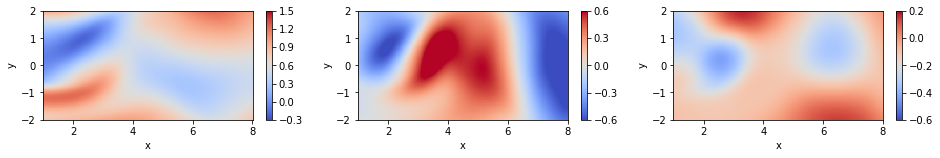

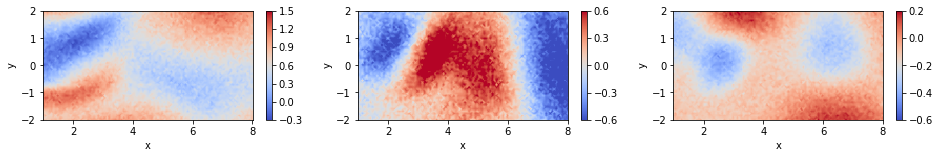

In [10]:
print("clean data vs noised data at:", tm)

plot_sol3(X_star, UU[:, tm], VV[:, tm], PP[:, tm], u0, u1, ut, v0, v1, vt, p0, p1, pt)
plot_sol3(X_star, UU_ns[:, tm], VV_ns[:, tm], PP_ns[:, tm], u0, u1, ut, v0, v1, vt, p0, p1, pt)

In [12]:
def time_matmul(x):
    start = time.time()
    for loop in range(100):
        tf.matmul(x, x)
    result = time.time()-start
    print("10 loops: {:0.2f}ms".format(1000*result))

# CPUでの実行を強制
print("On CPU:")
with tf.device("CPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("CPU:0")
    time_matmul(x)

# GPU #0があればその上での実行を強制
if tf.config.experimental.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("GPU:0"): # 2番めのGPUなら GPU:1, 3番目なら GPU:2 など
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

On CPU:
10 loops: 223.63ms
On GPU:
10 loops: 712.62ms


In [13]:
# t0 = time.time()

# print("""
# ************************************************************
# ****************      HYPER PARAMETERS      ****************
# ************************************************************
# """)

# print("learning rate  :", lr)
# print("# of epoch     :", n_epch)
# print("batch size     :", n_btch)
# print("convergence tol:", c_tol)
# print("N_trn          :", N_trn)
# print("N_val          :", N_val)

# print("""
# ************************************************************
# ****************     MAIN PROGRAM START     ****************
# ************************************************************
# """, ">>>>> start time:", datetime.datetime.now())

# model1 = PINN(x_trn, y_trn, t_trn, u_trn, v_trn, 
#               x_val, y_val, t_val, u_val, v_val, 
#               layers, activ = "tanh", w_init = "Glorot", 
#               w_prd = 1., w_pde = 1.)

# model1.train(epoch = n_epch, tol = c_tol)

# print("""
# ************************************************************
# *****************     MAIN PROGRAM END     *****************
# ************************************************************
# """, ">>>>> end time:", datetime.datetime.now())
# t1 = time.time()

# print("elps (min):", (t1 - t0) / 60.)
# print("elps  (hr):", (t1 - t0) / 60. / 60.)

In [7]:
t0 = time.time()

print("""
************************************************************
****************      HYPER PARAMETERS      ****************
************************************************************
""")

print("learning rate  :", lr)
print("# of epoch     :", n_epch)
print("batch size     :", n_btch)
print("convergence tol:", c_tol)
print("N_trn          :", N_trn)
print("N_val          :", N_val)

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

model2 = PINN2(x_trn, y_trn, t_trn, u_trn, v_trn, 
               x_val, y_val, t_val, u_val, v_val, 
               layers, activ = "tanh", w_init = "Glorot", 
               w_prd = 1., w_pde = 1.)

model2.train(epoch = n_epch, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************      HYPER PARAMETERS      ****************
************************************************************

learning rate  : 0.001
# of epoch     : 5000
batch size     : 128
convergence tol: 0.001
N_trn          : 6930
N_val          : 2970

************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-11 17:35:24.528409
>>>>> initial state; loss_trn: 5.877449e-01, loss_val: 5.994194e-01
ep: 0, loss_trn: 5.877449e-01, loss_val: 5.994194e-01, elps: 3.288


KeyboardInterrupt: 

In [14]:
t0 = time.time()

print("""
************************************************************
****************      HYPER PARAMETERS      ****************
************************************************************
""")

print("learning rate  :", lr)
print("# of epoch     :", n_epch)
print("batch size     :", n_btch)
print("convergence tol:", c_tol)
print("N_trn          :", N_trn)
print("N_val          :", N_val)

print("""
************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
""", ">>>>> start time:", datetime.datetime.now())

model3 = PINN3(x_trn, y_trn, t_trn, u_trn, v_trn, 
               x_val, y_val, t_val, u_val, v_val, 
               layers, activ = "tanh", w_init = "Glorot", 
               w_prd = 1., w_pde = 1.)
with tf.device("GPU:0"):
    model3.train(epoch = n_epch, tol = c_tol)

print("""
************************************************************
*****************     MAIN PROGRAM END     *****************
************************************************************
""", ">>>>> end time:", datetime.datetime.now())
t1 = time.time()

print("elps (min):", (t1 - t0) / 60.)
print("elps  (hr):", (t1 - t0) / 60. / 60.)


************************************************************
****************      HYPER PARAMETERS      ****************
************************************************************

learning rate  : 0.001
# of epoch     : 5000
batch size     : 128
convergence tol: 0.001
N_trn          : 6930
N_val          : 2970

************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
 >>>>> start time: 2021-10-11 14:54:28.043332
>>>>> initial state; loss_trn: 5.854925e-01, loss_val: 5.933309e-01
ep: 0, loss_trn: 5.854925e-01, loss_val: 5.933309e-01, elps: 2.560


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (16, 3))

plt.subplot(1, 2, 1)
plt.plot(model2.ep_log, model2.loss_trn_log, label = "loss_trn")
plt.plot(model2.ep_log, model2.loss_val_log, label = "loss_val")
plt.yscale("log")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model3.ep_log, model3.loss_trn_log, label = "loss_trn")
plt.plot(model3.ep_log, model3.loss_val_log, label = "loss_val")
plt.yscale("log")
plt.legend()

In [ ]:
model2.params

In [ ]:
model2.dist_U

In [ ]:
len(model2.dist_U)

In [ ]:
print(model2.dist_U[0])
print(model2.dist_U[1])
print(model2.dist_U[2])

In [ ]:
plt.hist(model2.dist_U[0], range = (-1.5, 1.5))
plt.show()

In [ ]:
plt.hist(model2.dist_U[1], range = (-1.5, 1.5))
plt.show()

In [ ]:
plt.hist(model2.dist_U[2], range = (-1.5, 1.5))
plt.show()

In [ ]:
plt.hist(model2.dist_U, range = (-1.5, 1.5), density = True)
plt.show()

In [ ]:
tm = 100
tm = np.array([tm])
x_star    = X_star[:,0:1]; y_star    = X_star[:,1:2]; t_star    = TT[:,tm]
u_star    = UU   [:,tm];   v_star    = VV   [:,tm];   p_star    = PP[:,tm]
u_star_ns = UU_ns[:,tm];   v_star_ns = VV_ns[:,tm];   p_star_ns = PP_ns[:,tm]

u_hat, v_hat, p_hat, gv_c_hat, gv_x_hat, gv_y_hat = model2.predict(x_star, y_star, t_star)

print("u_hat   :", u_hat)
print("gv_c_hat:", gv_c_hat)
print("gv_x_hat:", gv_x_hat)

In [ ]:
plot_diff(X_star, u_star, u_hat.numpy(), u0, u1, ut)
plot_diff(X_star, v_star, v_hat.numpy(), v0, v1, vt)